### **Imports**

In [1]:
import pandas as pd
from sklearn import model_selection
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.applications.imagenet_utils import preprocess_input
from keras.regularizers import *
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)


Using TensorFlow backend.


### **Mount & set directory**


In [2]:
from google.colab import drive
drive.mount('/content/drive')
home_dir = '/content/drive/My Drive/Colab Notebooks/FER/'
baum_dir = home_dir + 'BAUM/'
data = pd.read_csv(baum_dir + 'training_data.csv', dtype={'flow': str, 'spatial': str, 'code': str})
data_valid = pd.read_csv(baum_dir + 'validation_data.csv', dtype={'flow': str, 'spatial': str, 'code': str})
# drop odd elements
#data = data.iloc[range(0,len(data),2)]
#print (data.head())


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### **Data Analysis and Visualization**

Unique classes are:  ['8', '10', '1', '6', '7', '11']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.


['Sadness', 'Happiness', 'Sadness', 'Disgust', 'Disgust']
['sadness', 'Happiness', 'Happiness', 'Happiness', 'Surprise']


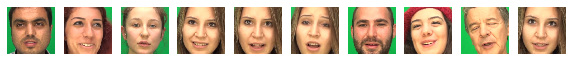

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
data_unique = data['code'].unique().tolist()
print("Unique classes are: ",data_unique)

images = []
images_flow = []
emotions = []
codes = []
i = 0
while i < 10:
  sample = data.sample()

  spatial = sample['spatial'] 
  emotion = sample['emotion'] 
  code = sample['code']

  spatial = spatial.get_values()[0]
  emotion = emotion.get_values()[0]
  code = code.get_values()[0]

  img_path = baum_dir + spatial
  if (os.path.isfile(img_path)):
    images.append(mpimg.imread(img_path))
    emotions.append(emotion)
    codes.append(code)
    i+=1

plt.figure(figsize=(10,15))
columns = 10

for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')

print(emotions[:5])
print(emotions[5:])


### **Image generators**

In [4]:
X_train, _, y_train, _ = model_selection.train_test_split(data['spatial'], data['code'], test_size=0.01)
_, X_test, _, y_test = model_selection.train_test_split(data_valid['spatial'], data_valid['code'], test_size=0.99)

print("Trainig data: ", len(X_train), "Trainig labels: ", len(y_train))
print("Test data: ", len(X_test), "Test labels: ", len(y_test))

train_df = pd.concat([X_train, y_train], axis=1, sort=False)
valid_df = pd.concat([X_test, y_test], axis=1, sort=False)


batch_size_ = 256

train_datagen = ImageDataGenerator(#rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator()#rescale=1./255,


train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='',
        x_col="spatial",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory='',
        x_col="spatial",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical')

print ("generators initiaized")

Trainig data:  51837 Trainig labels:  51837
Test data:  8055 Test labels:  8055
Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.
generators initiaized


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 51837 invalid image filename(s) in x_col="spatial". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 8055 invalid image filename(s) in x_col="spatial". These filename(s) will be ignored.
  .format(n_invalid, x_col)


### **Model & setting**

In [5]:

# Create Model
def create_model():
  input_spatial = Input(shape=(48,48,3))
  x = layers.Conv2D(64, (5, 5), activation='relu')(input_spatial)
  x = layers.MaxPooling2D(pool_size=(5,5), strides=(2, 2))(x)
  x = layers.Conv2D(64, (3, 3), activation='relu')(x)
  x = layers.Conv2D(64, (3, 3), activation='relu')(x)
  x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
  x = layers.Conv2D(128, (3, 3), activation='relu')(x)
  x = layers.Conv2D(128, (3, 3), activation='relu')(x)

  x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
  x = layers.Flatten()(x)

  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.6)(x)
  x = layers.Dense(1024, activation='relu',
                kernel_regularizer=l2(0.01),
                activity_regularizer=l1(0.01))(x)

  x = layers.Dropout(0.6)(x)

  Out = layers.Dense(6, activation='softmax')(x)
  model = models.Model(inputs=[input_spatial], outputs=[Out])
  return model

model = create_model()
print (model.summary())

model.compile(optimizer = "Adam",
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 44, 44, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
average_pooling2d (AveragePo (None, 7, 7, 64)          0         
______________________________________________

### **Train**

In [0]:
# Auto-save model weights with best val_acc
modelPath  = baum_dir + 'models/kaggle_spatial.h5'
checkpoint = ModelCheckpoint(modelPath,
                             monitor = 'val_acc',
                             verbose = 1,
                             save_best_only = True,
                             mode = 'max')
callbacks_list = [checkpoint]

# Train The Model
model.fit_generator(
        train_generator,
        steps_per_epoch=1000,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=400,
        callbacks = callbacks_list)

Epoch 1/50


### **End**